# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [398]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [359]:
DEVICE = 'cuda:0'
NDIM = 4 # number of parameters
SIGMA = 0.01

In [360]:
# A toy model with a diffuse and point source component

def model(z):
    grid = np.linspace(0, 1, 50, 50)
    X, Y = np.meshgrid(grid, grid)
    x0, y0, r, w = z[0], z[1], z[2]*0.4+0.2, z[3]*0.1+0.05
    
    R = ((X-x0)**2 + (Y-y0)**2)**0.5
    
    mu = np.exp(-(R-r)**2/w**2/2)
    x = mu
    return x

In [361]:
def noisemodel(x, z = None, noiselevel = 1.):
    n = np.random.randn(*x.shape)*SIGMA  #*noiselevel
    return x + n

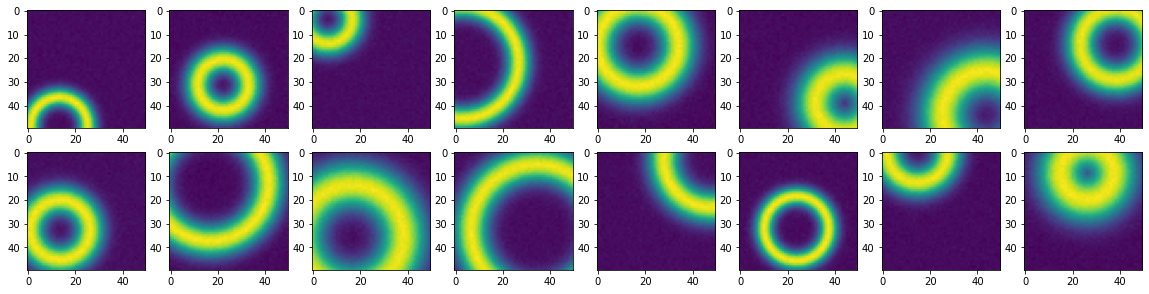

In [362]:
# Random image realizations

plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 8, i+1)
    z = np.random.rand(5)
    x = model(z)
    x = noisemodel(x)
    plt.imshow(x)

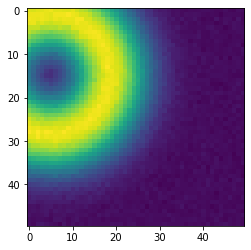

In [363]:
z0 = np.array([0.1, 0.3, 0.2, 0.8])
x0 = noisemodel(model(z0))
plt.imshow(x0)

In [364]:
# Fisher analysis
grad = []

for i in range(0, NDIM):
    dz = np.zeros(NDIM)
    d = 0.001
    dz[i] += d
    g = (model(z0+dz) - model(z0))/d
    grad.append(g)

I = np.zeros((NDIM, NDIM))

for i in range(NDIM):
    for j in range(NDIM):
        I[i, j] = (grad[i]*grad[j]).sum()/SIGMA**2
        
        
Cov = np.linalg.inv(I)
err = np.diag(Cov)**0.5
print(err)

[0.00018608 0.0001329  0.00031023 0.00085264]


In [365]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv0a = torch.nn.Conv2d(1, 100, 1)
        #self.conv0b = torch.nn.Conv2d(100, 1, 1)
        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        #x = self.conv0a(x)
        #x = torch.relu(x)
        #x = self.conv0b(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [366]:
# Instantiate network
sw = swyft.SWYFT(x0, model, zdim = NDIM, device = DEVICE, head = Head, noisemodel = noisemodel)
sw.run(nrounds = 4, max_epochs = 20, early_stopping_patience = 3, nsamples = 2500, nbatch = 32, recycle_net = False, threshold = 1e-8)
%time

Number of output features: 160
Start training
LR iteration 0
Total epochs: 15
Validation losses: [10.135679006576538, 8.951716125011444, 8.095718294382095, 7.485469222068787, 7.3515192568302155, 6.880486935377121, 6.52604016661644, 6.350142270326614, 5.8230694234371185, 5.716553062200546, 5.541291505098343, 5.150818556547165, 5.346496611833572, 5.64021298289299, 5.275781661272049]
LR iteration 1
Total epochs: 9
Validation losses: [4.573855206370354, 4.424980327486992, 4.374807730317116, 4.341329827904701, 4.326916754245758, 4.317029073834419, 4.326050132513046, 4.34599956870079, 4.3609360456466675]
LR iteration 2
Total epochs: 7
Validation losses: [4.27359464764595, 4.26137338578701, 4.2571341544389725, 4.255737736821175, 4.256117299199104, 4.2565726935863495, 4.257359877228737]
Constrained posterior volume: 0.046620028121999994
Number of output features: 160
Start training
LR iteration 0
Total epochs: 11
Validation losses: [8.541375041007996, 6.8233702480793, 6.460664987564087, 6.2154

1.0334338701614199 2.1453600911623103
1.1673638390560004 2.5601497050758266
1.1647671204158638 3.020952684288906
0.8859000284336186 1.9224836993990655


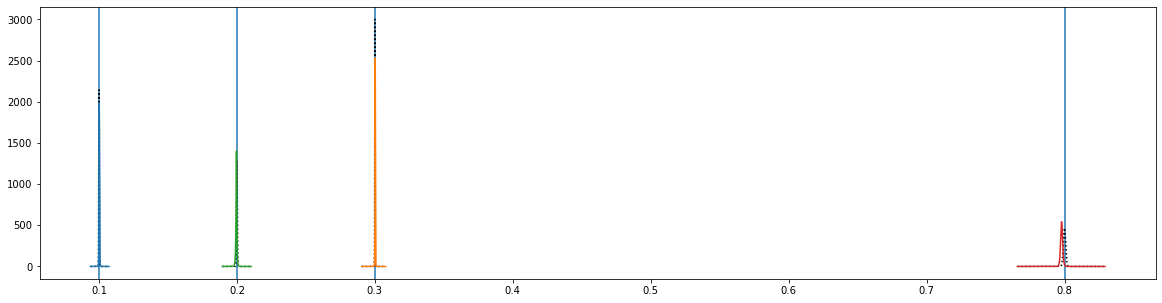

In [396]:
plt.figure(figsize=(20, 5))
for i in range(4):
    z, p = sw.posterior(i, version = 3)
    plt.axvline(z0[i])
    plt.plot(z, stats.norm.pdf(z, z0[i], err[i]), 'k:')
    plt.plot(z, p)
    s = swyft.get_stats(z, p)
    print(s['err68']/err[i], s['err95']/err[i])
#plt.xlim([0.79, 0.81])

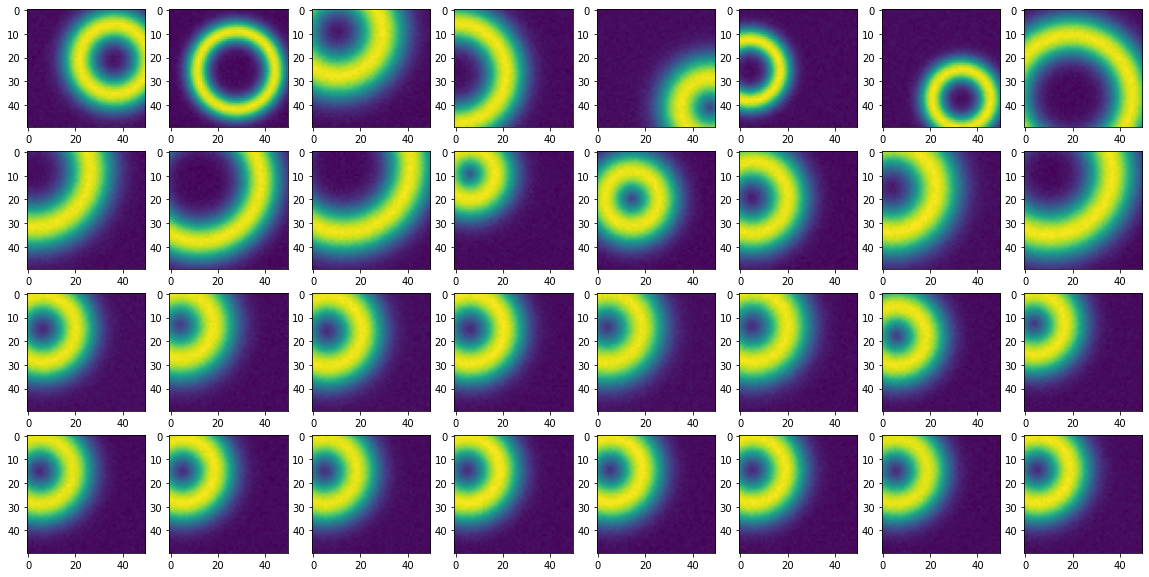

In [379]:
# Training data in different rounds (without noise)

plt.figure(figsize=(20, 10))
counter = 0
for r in range(4):
    imgs = swyft.get_x(sw.data_store[r])
    for i in range(8):
        counter += 1
        plt.subplot(4, 8, counter)
        plt.imshow(imgs[i])